In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import uproot
import awkward as ak

In [2]:
plt.rc('font', size=14)

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ParamsCVAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, params_dim, label_dim):
        super(ParamsCVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim+params_dim+label_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim, bias=True)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim, bias=True)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim+params_dim+label_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim, bias=True),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, hist, params, labels):
        x = hist.view(hist.size(0), -1)
        x = torch.cat((x, params, labels), dim=1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = torch.cat((z, params, labels), dim=1)
        reco_hist = self.decode(z)
        return reco_hist, mu, logvar

In [5]:
class CVAELoss(nn.Module):
    def __init__(self):
        super(CVAELoss, self).__init__()

    def forward(self, reco_hist, hist, mu, logvar):
        hist = hist.view(hist.size(0), -1)
        reco_fn = nn.BCELoss(reduction="sum")
        reconstruction = reco_fn(reco_hist, hist)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return (reconstruction + kl_divergence)/reco_hist.size(0)

In [6]:
# Load histograms

X0_tree = uproot.open("MCHist.root:X0_train")
X0 = X0_tree["hist"].array(library="np")
theta0 = X0_tree["thetas"].array(library="np")
Y0 = X0_tree["label"].array(library="np")

X1_tree = uproot.open("MCHist.root:X1_train")
X1 = X1_tree["hist"].array(library="np")
theta1 = X1_tree["thetas"].array(library="np")
Y1 = X1_tree["label"].array(library="np")

hist = np.concatenate((X0, X1))
thetas = np.concatenate((theta0, theta1))
label = np.concatenate((Y0, Y1))

In [7]:
# split train and validation

X_train, X_val, theta_train, theta_val, label_train, label_val = train_test_split(hist, thetas, label, test_size=0.4, shuffle=True)

In [8]:
# convert to pytorch tensor

batch_size = 128

X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
theta_train_tensor = torch.from_numpy(theta_train).float()
theta_val_tensor = torch.from_numpy(theta_val).float()
label_train_tensor = torch.from_numpy(label_train).float()
label_val_tensor = torch.from_numpy(label_val).float()

# make data set
train_dataset = TensorDataset(X_train_tensor, theta_train_tensor, label_train_tensor)
val_dataset = TensorDataset(X_val_tensor, theta_val_tensor, label_val_tensor)

# make data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# CVAE
hidden_dim = 64
latent_dim = 32
params_dim = 3
label_dim = 2
input_dim = 20*20

params_cvae = ParamsCVAE(hidden_dim, latent_dim, input_dim, params_dim, label_dim)

In [10]:
# Model summary
print("using device : {}".format(device))
total_trainable_params = sum(p.numel() for p in params_cvae.parameters() if p.requires_grad)
print(params_cvae)
print('total trainable params: {}'.format(total_trainable_params))

using device : cpu
ParamsCVAE(
  (encoder): Sequential(
    (0): Linear(in_features=405, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=64, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=400, bias=True)
    (3): Sigmoid()
  )
)
total trainable params: 62736


In [11]:
# loss fucntion

num_epochs = 200
learning_rate = 0.001
early_stopping_patience = 20


criterion = CVAELoss()
optimizer = optim.Adam(params_cvae.parameters(), lr=learning_rate)

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, early_stopping_patience):

    model = model.to(device)
    
    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_hist, batch_params, batch_labels in train_loader:
            batch_hist = batch_hist.to(device)
            batch_params = batch_params.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            reco_hist, mu, logvar = model(batch_hist, batch_params, batch_labels)
            loss = criterion(reco_hist, batch_hist, mu, logvar)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_hist.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluation
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            for batch_hist, batch_params, batch_labels in val_loader:
                batch_hist = batch_hist.to(device)
                batch_params = batch_params.to(device)
                batch_labels = batch_labels.to(device)

                reco_hist, mu, logvar = model(batch_hist, batch_params, batch_labels)
                loss = criterion(reco_hist, batch_hist, mu, logvar)

                running_loss += loss.item() * batch_hist.size(0)

            validation_loss = running_loss / len(val_loader.dataset)

            print("Epoch {}: Train Loss = {:.4f}, Test Loss = {:.4f}".format(epoch + 1, epoch_loss, validation_loss))

            # Check for early stopping
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_model_weights = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print("Early stopping at epoch {}".format(epoch))
                break

    return best_model_weights

In [13]:
best_model_weights = train_model(params_cvae, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs, early_stopping_patience)

Epoch 1: Train Loss = 147.2187, Test Loss = 135.4587
Epoch 2: Train Loss = 134.7579, Test Loss = 134.4797
Epoch 3: Train Loss = 134.4146, Test Loss = 134.3570
Epoch 4: Train Loss = 134.3341, Test Loss = 134.2879
Epoch 5: Train Loss = 134.2229, Test Loss = 134.1426
Epoch 6: Train Loss = 134.1066, Test Loss = 134.0603
Epoch 7: Train Loss = 134.0497, Test Loss = 134.0298
Epoch 8: Train Loss = 134.0336, Test Loss = 134.0222
Epoch 9: Train Loss = 134.0280, Test Loss = 134.0175
Epoch 10: Train Loss = 134.0240, Test Loss = 134.0146
Epoch 11: Train Loss = 134.0211, Test Loss = 134.0117
Epoch 12: Train Loss = 134.0193, Test Loss = 134.0092
Epoch 13: Train Loss = 134.0178, Test Loss = 134.0088
Epoch 14: Train Loss = 134.0171, Test Loss = 134.0078
Epoch 15: Train Loss = 134.0162, Test Loss = 134.0077
Epoch 16: Train Loss = 134.0156, Test Loss = 134.0079
Epoch 17: Train Loss = 134.0150, Test Loss = 134.0076
Epoch 18: Train Loss = 134.0147, Test Loss = 134.0053
Epoch 19: Train Loss = 134.0141, Test

In [14]:
# module used to add parameter for fitting
class AddParams2Input(nn.Module):
    def __init__(self, params):
        super(AddParams2Input, self).__init__()
        self.params = nn.Parameter(torch.Tensor(params), requires_grad=True)

    def forward(self, inputs):
        # inputs = inputs.view(inputs.size(0), -1)
        batch_params = torch.ones((inputs.size(0), 1), device=inputs.device) * self.params.to(device=inputs.device)
        # concatenated = torch.cat([inputs, batch_params], dim=-1)
        return inputs, batch_params

In [15]:
# Test histograms

X0_test = uproot.open("MCHist.root:X0_test")
X0 = X0_test["hist"].array(library="np")
theta0 = X0_test["thetas"].array(library="np")
Y0 = X0_test["label"].array(library="np")

X1_test = uproot.open("MCHist.root:X1_test")
X1 = X1_test["hist"].array(library="np")
theta1 = X1_test["thetas"].array(library="np")
Y1 = X1_test["label"].array(library="np")

hist = np.concatenate((X0, X1))
thetas = np.concatenate((theta0, theta1))
label = np.concatenate((Y0, Y1))

In [16]:
hist_tensor = torch.from_numpy(hist).float()
thetas_tensor = torch.from_numpy(thetas).float()
label_tensor = torch.from_numpy(label).float()

test_dataset = TensorDataset(hist_tensor, label_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
# Load the best model weights
params_cvae.load_state_dict(best_model_weights)

# Define the parameters
mu_fit_init = [1., 0., 0.]

# Create the AddParams2Input layer
add_params_layer = AddParams2Input(mu_fit_init)

In [18]:
# Set all weights in fit model to non-trainable
for param in params_cvae.parameters():
    param.requires_grad = False

In [19]:
# Model summary
print("using device : {}".format(device))
fit_trainable_params = sum(p.numel() for p in params_cvae.parameters() if p.requires_grad)
print(params_cvae)
print('total trainable params in fit model: {}'.format(fit_trainable_params))

total_trainable_params = sum(p.numel() for p in add_params_layer.parameters() if p.requires_grad)
print(add_params_layer)
print('total trainable params in fit model: {}'.format(total_trainable_params))

using device : cpu
ParamsCVAE(
  (encoder): Sequential(
    (0): Linear(in_features=405, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=64, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=400, bias=True)
    (3): Sigmoid()
  )
)
total trainable params in fit model: 0
AddParams2Input()
total trainable params in fit model: 3


In [20]:
# Fit the model
def fit_fn(num_epochs, add_params_layer, params_cvae, data_loader, device, optimizer, loss_fn):
    losses = []
    fit_vals = {"lambda": [], "mu": [], "nu": []}

    add_params_layer = add_params_layer.to(device)
    params_cvae = params_cvae.to(device)

    for epoch in range(num_epochs):
        add_params_layer.train()
        running_loss = 0.0
        for batch_hist, batch_labels in data_loader:
            batch_hist = batch_hist.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            batch_inputs, batch_params = add_params_layer(batch_hist)
            output, mu, logvar = params_cvae(batch_hist, batch_params, batch_labels)

            # Compute the loss
            loss = loss_fn(output, batch_hist, mu, logvar)

            # Backward pass and update weights
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_inputs.size(0)

        epoch_loss = running_loss / len(data_loader.dataset)
        print("epoch : {}, loss = {:.4f}, nu = {:.4f}".format(epoch + 1, epoch_loss, add_params_layer.params[2].item()))
        losses.append(epoch_loss)
        fit_vals["lambda"].append(add_params_layer.params[0].item())
        fit_vals["mu"].append(add_params_layer.params[1].item())
        fit_vals["nu"].append(add_params_layer.params[2].item())

    return losses, fit_vals

In [21]:
criterion = CVAELoss()
optimizer = optim.Adam(add_params_layer.parameters(), lr=learning_rate)

In [22]:
loss, fit_vals = fit_fn(num_epochs, add_params_layer, params_cvae, test_dataloader, device, optimizer, criterion)

epoch : 1, loss = 134.3319, nu = 0.1953
epoch : 2, loss = 134.3176, nu = 0.2224
epoch : 3, loss = 134.3174, nu = 0.2243
epoch : 4, loss = 134.3174, nu = 0.2230
epoch : 5, loss = 134.3174, nu = 0.2228
epoch : 6, loss = 134.3174, nu = 0.2238
epoch : 7, loss = 134.3174, nu = 0.2254
epoch : 8, loss = 134.3174, nu = 0.2215
epoch : 9, loss = 134.3174, nu = 0.2239
epoch : 10, loss = 134.3174, nu = 0.2247
epoch : 11, loss = 134.3174, nu = 0.2226
epoch : 12, loss = 134.3174, nu = 0.2237
epoch : 13, loss = 134.3174, nu = 0.2243
epoch : 14, loss = 134.3174, nu = 0.2243
epoch : 15, loss = 134.3175, nu = 0.2239
epoch : 16, loss = 134.3174, nu = 0.2225
epoch : 17, loss = 134.3174, nu = 0.2243
epoch : 18, loss = 134.3174, nu = 0.2213
epoch : 19, loss = 134.3174, nu = 0.2210
epoch : 20, loss = 134.3174, nu = 0.2231
epoch : 21, loss = 134.3174, nu = 0.2243
epoch : 22, loss = 134.3174, nu = 0.2209
epoch : 23, loss = 134.3174, nu = 0.2254
epoch : 24, loss = 134.3174, nu = 0.2246
epoch : 25, loss = 134.31

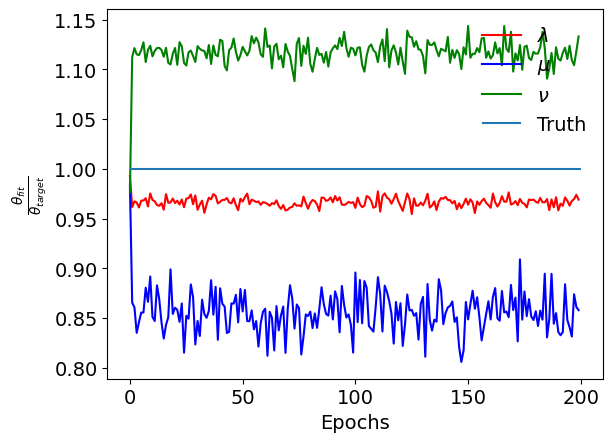

In [23]:
fit_vals["lambda"] = np.array(fit_vals["lambda"])
fit_vals["mu"] = np.array(fit_vals["mu"])
fit_vals["nu"] = np.array(fit_vals["nu"])

targets = [0.8, -0.1, 0.2]

plt.plot(fit_vals["lambda"]/targets[0], label=r'$\lambda$', color='r')
plt.plot(fit_vals["mu"]/targets[1], label=r'$\mu$', color='b')
plt.plot(fit_vals["nu"]/targets[2], label=r'$\nu$', color='g')
plt.hlines(1.0, 0, len(fit_vals["lambda"]), label='Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\frac{\theta_{fit}}{\theta_{target}}$')
plt.legend(frameon=False)
plt.show()